In [135]:
import os
import cv2
import numpy as np
from scipy.spatial import distance as dist
from scipy.spatial.distance import cdist
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time


## Creating the simplified version of findpeak and meanshift

In [136]:
def findpeak(data, idx, r):
    """
    Function to find the peak within a given radius for a data point.

    Parameters:
    - data: NumPy array of shape (N, D) containing N data points of dimension D.
    - idx: Index of the current data point for which to find the peak.
    - r: Radius within which to search for the peak.

    Returns:
    - current_point: The found peak for the current data point.
    """

    # Get the current data point
    current_point = data[idx]

    # Iterate until convergence (finding the peak)
    while True:
        # Find all points within the specified radius
        points_in_radius = data[np.linalg.norm(data - current_point, axis=1) < r]

        # Calculate the mean of the points within the radius
        mean_point = np.mean(points_in_radius, axis=0)

        # Check convergence condition
        if np.linalg.norm(mean_point - current_point) < 1e-6:
            break

        # Update the current point to the mean point
        current_point = mean_point

    # Return the found peak for the current data point
    return current_point


def meanshift(data, r):
    """
    Function to perform mean shift clustering on the given data.

    Parameters:
    - data: NumPy array of shape (N, D) containing N data points of dimension D.
    - r: Radius to define the search space for peaks.

    Returns:
    - labels: NumPy array of shape (N,) containing the assigned label for each data point.
    - peaks: NumPy array of shape (D, M) containing the M found peaks, each as a column vector of dimension D.
    """

    # Initialize labels and peaks
    labels = -1 * np.ones(data.shape[0], dtype=int)  # -1 indicates unassigned label
    peaks = []

    # Iterate over each data point
    for idx in range(data.shape[0]):
        # Find the peak for the current data point
        peak = findpeak(data, idx, r)

        # Check if the peak is close to any of the existing peaks
        for i, existing_peak in enumerate(peaks):
            if np.linalg.norm(peak - existing_peak) < r / 2:
                # If the peak is close to an existing peak, assign the label of the existing peak
                labels[idx] = i
                break
        else:
            # If the peak is not close to any existing peak, add it to the list of peaks and assign a new label
            peaks.append(peak)
            labels[idx] = len(peaks) - 1

    # Convert peaks list to a matrix (each peak as a column)
    peaks = np.array(peaks).T

    # Return the assigned labels and peaks
    return labels, peaks


## Creating the optimized version of findpeak and meanshift

In [137]:
def findpeak_opt(data, r, c, threshold=0.01):
    """
    Function to find peaks using an optimized version of the mean shift algorithm.

    Parameters:
    - data: NumPy array of shape (N, D) containing N data points of dimension D.
    - r: Radius to define the search space for peaks.
    - c: Constant factor to determine the convergence threshold.
    - threshold: Convergence threshold to control the stop condition.

    Returns:
    - peaks: NumPy array containing the found peaks.
    - labels: NumPy array of shape (N,) containing the assigned label for each data point.
    """

    peaks = []  # List to store the found peaks
    labels = np.full(len(data), -1)  # Array to store the assigned label for each data point (-1 indicates unassigned)

    # Iterate over each data point
    for count, p in enumerate(data):
        if labels[count] == -1:
            add_pixels = np.zeros(len(data))  # Array to track points within the adjusted radius
            shift = 5  # Initialize the shift value (greater than the threshold)

            while shift > threshold:
                # Calculate distances from the current point to all other points
                dist_pixel = cdist([p], data)[0]

                # Select points within the specified radius and the adjusted radius
                window = data[dist_pixel < r]
                add_pixels[dist_pixel < r / c] = 1

                # Calculate the center of mass within the window
                center_mass = window.mean(axis=0)

                # Calculate the shift between the current point and the center of mass
                shift = dist.euclidean(p, center_mass)

                # Update the current point to the center of mass
                p = center_mass

            if len(peaks) == 0:
                # If no peaks exist, add the center of mass as a new peak
                peaks.append(center_mass)
                labels[cdist([center_mass], data)[0] < r] = len(peaks) - 1
                labels[add_pixels == 1] = len(peaks) - 1
                continue

            # Check if the center of mass is close to any existing peaks
            distances = cdist([center_mass], peaks)

            if distances.min() > r / 2:
                # If not close to any existing peaks, add the center of mass as a new peak
                peaks.append(center_mass)
                labels[cdist([center_mass], data)[0] < r] = len(peaks) - 1
                labels[add_pixels == 1] = len(peaks) - 1
            else:
                # If close to an existing peak, assign the label of the closest peak
                labels[count] = distances.argmin()
                labels[add_pixels == 1] = distances.argmin()
        else:
            continue

    return np.array(peaks), labels


def meanshift_opt(data, peaks, r, c, threshold=0.01):
    """
    Function to perform mean shift clustering using optimized peak shifting.

    Parameters:
    - data: NumPy array of shape (N, D) containing N data points of dimension D.
    - peaks: NumPy array containing the initial peaks.
    - r: Radius to define the search space for peaks.
    - c: Constant factor to determine the convergence threshold.
    - threshold: Convergence threshold to control the stop condition. Should never be higher than 5!

    Returns:
    - shifted_peaks: NumPy array containing the shifted peaks.
    """

    shifted_peaks = []  # List to store the shifted peaks

    # Iterate over each peak
    for p in peaks:
        shift = 5  # Initialize the shift value (greater than the threshold)

        while shift > threshold:
            # Calculate distances from the current peak to all data points
            distances = dist.cdist([p], data)[0]

            # Select points within the specified radius
            window = data[distances < r]

            # Calculate the center of mass within the window
            center_mass = window.mean(axis=0)

            # Calculate the shift between the current peak and the center of mass
            shift = dist.euclidean(p, center_mass)

            # Update the current peak to the center of mass
            p = center_mass

        shifted_peaks.append(center_mass)

    return np.array(shifted_peaks)


In [138]:
def visualize_meanshift_opt(data, r, c, threshold=0.01):
    """
    Function to visualize the Mean Shift clustering using optimized peak shifting.

    Parameters:
    - data: NumPy array of shape (N, D) containing N data points of dimension D.
    - r: Radius to define the search space for peaks.
    - c: Constant factor to determine the convergence threshold.
    - threshold: Convergence threshold to control the stop condition.
    """

    # Perform Mean Shift clustering
    initial_peaks, labels = findpeak_opt(data, r, c, threshold)
    peaks = meanshift_opt(data, initial_peaks, r, c, threshold)

    # Create a 3D scatter plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    for i, peak in enumerate(peaks):
        # Plot the points belonging to this peak
        cluster_data = data[labels == i]
        if cluster_data.ndim == 1:
            ax.scatter(cluster_data[0], cluster_data[1], cluster_data[2], s=10)
        else:
            ax.scatter(cluster_data[:, 0], cluster_data[:, 1], cluster_data[:, 2], s=10)

        # Plot the peak
        ax.scatter(peak[0], peak[1], peak[2], s=100, c='black')

    plt.show()


def visualize_meanshift(data, r):
    """
    Function to visualize the Mean Shift clustering.

    Parameters:
    - data: NumPy array of shape (N, D) containing N data points of dimension D.
    - r: Radius to define the search space for peaks.
    """

    # Perform Mean Shift clustering
    labels, peaks = meanshift(data.T, r)

    # Create a 3D scatter plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    for i, peak in enumerate(peaks.T):
        # Plot the points belonging to this peak
        ax.scatter(*data[:, labels == i], s=10)

        # Plot the peak
        ax.scatter(*peak, s=100, c='black')

    plt.show()


In [194]:
def segmIm(path_img, r, c, threshold=0.01, add_pos=True):
    """
    Function to perform image segmentation using Mean Shift algorithm.

    Parameters:
    - img: NumPy array representing the input image.
    - r: Radius to define the search space for peaks.
    - c: Constant factor to determine the convergence threshold.
    - threshold: Convergence threshold to control the stop condition.
    - add_pos: Boolean flag to specify whether to add positional information to the feature vector.

    Returns:
    - peaks: NumPy array containing the found peaks.
    - labels: NumPy array of shape (N,) containing the assigned label for each data point.
    - rec_img: NumPy array representing the segmented image.
    """

    # First, we implement some preprocessing steps for the image used

    # Used for plotting in the end
    input_img = cv2.imread(path_img)
    original_img = cv2.cvtColor(input_img, cv2.COLOR_RGB2BGR)
    #orig_img = original_img.astype(np.float32)/255.0

    # Used for mean shift
    img = cv2.cvtColor(input_img, cv2.COLOR_RGB2LAB)
    #img = image.astype(np.float32)/255.0
    shape = img.shape

    # Add positional information to feature vector
    if add_pos:
        indices = np.ones((img.shape[0], img.shape[1], 2))
        row, column = np.indices(img.shape[0:2])
        indices[:, :, 0] = row
        indices[:, :, 1] = column
        img = np.append(img, indices, axis=2)
        img = img.reshape(-1, img.shape[-1])
    else:
        img = img.reshape(-1, img.shape[-1])

    # Call findpeak_opt and meanshift_opt functions
    peaks, labels = findpeak_opt(img, r, c, threshold)
    shifted_peaks = meanshift_opt(img, peaks, r, c)

    # Reconstruct image from shifted peaks and labels
    rec_img = np.zeros(shape, dtype="uint8")
    rec_img = rec_img.reshape(-1, 3)
    for unique in np.unique(labels):
        rec_img[labels == unique] = shifted_peaks[unique][0:3]
    rec_img = rec_img.reshape(shape)
    rec_img = cv2.cvtColor(rec_img, cv2.COLOR_LAB2BGR)

    # Plot image
    f, ax = plt.subplots(1, 2, figsize=(12, 8))
    ax[0].imshow(original_img)
    ax[0].set_title("Original")
    ax[1].imshow(rec_img)
    ax[1].set_title("Segmented")
    
    # Extract the file name from the input path
    num_segments = len(np.unique(labels)) # number of segments in the image
    file_name = os.path.splitext(os.path.basename(path_img))[0]  # Extract the file name without extension
    params = f"_r={r}_c={c}_threshold={threshold}_segments={num_segments}"  # Parameters for the title
    save_path = f"{file_name}{params}.png"  # Save path for the segmented image
    plt.savefig(save_path)


    return peaks, labels, rec_img



In [195]:
path_img_1 = 'img_1.jpg'
path_img_2 = 'img_2.jpg'
path_img_3 = 'img_3.jpg'

img_1 = cv2.imread(path_img_1)
img_2 = cv2.imread(path_img_2)
img_3 = cv2.imread(path_img_3)

img_list = [path_img_1, path_img_2, path_img_3]


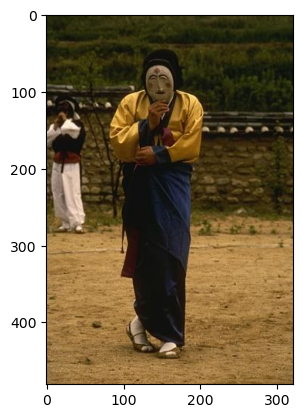

In [196]:
plt.imshow(cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB))


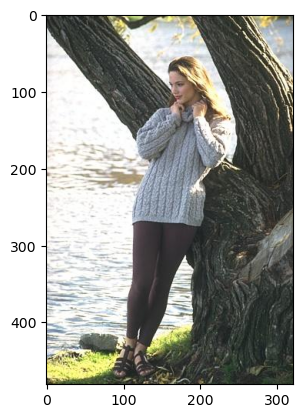

In [197]:
plt.imshow(cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB))


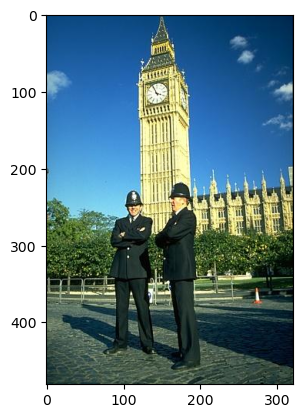

In [198]:
plt.imshow(cv2.cvtColor(img_3, cv2.COLOR_BGR2RGB))


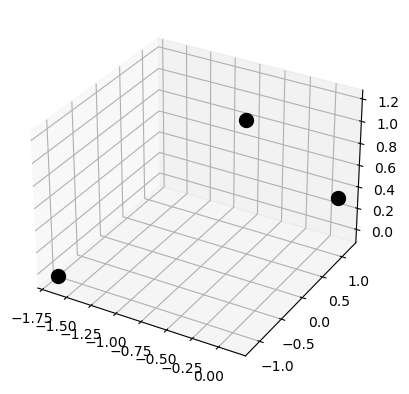

In [199]:
import scipy.io
mat = scipy.io.loadmat('pts.mat')
array_data = np.array(mat['data'])
array_data

r = 2
c = 4
threshold = 0.01

visualize_meanshift_opt(array_data, r, c, threshold)


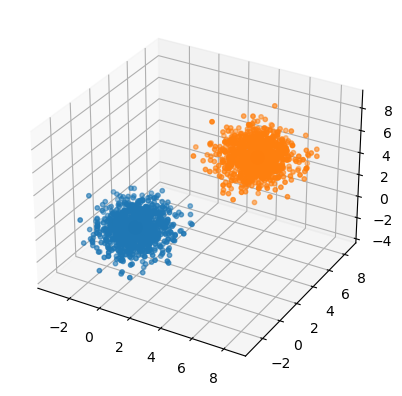

In [200]:
visualize_meanshift(array_data, r=2)


In [201]:
r = 2
c = 4
threshold = 0.01
# Checking the speed of the functions
start = time.time()
peaks = meanshift(array_data, r)
end = time.time()
print('meanshift speed:', end - start)

start = time.time()
peaks, _ = findpeak_opt(array_data, r, c, threshold)  # You can also use meanshift function here
shifted_peaks = meanshift_opt(array_data, peaks, r, c)
end = time.time()
print('meanshift optimized speed:', end - start)


meanshift speed: 0.0012657642364501953
meanshift optimized speed: 0.0006649494171142578


In [202]:
r = 20
c = 4
threshold = 0.01


In [ ]:
peaks,labels, rec_img  =segmIm(path_img_1, r, c, threshold, True)


In [ ]:
for img in img_list:
    start = time.time()
    peaks,labels, rec_img  =segmIm(img, r, c, threshold, False)
    end = time.time()
    print(f'time necessary: {img} ', end-start)
    

In [ ]:
for img in img_list:
    start = time.time()
    peaks,labels, rec_img  =segmIm(img, r, c, threshold, True)
    end = time.time()
    print('time necessary: ', end-start)
